<a href="https://colab.research.google.com/github/danteaguirreb/machine_learning/blob/tareas/proyecto_marketing_bancario_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto integrado de Machine Learning para marketing bancario

Tercera evaluación – Magíster / Curso de Machine Learning  
Universidad del Desarrollo – Facultad de Ingeniería

En este notebook se desarrolla de manera completa el proyecto de **segmentación y predicción de contratación de depósitos a plazo** para el Banco de Portugal, utilizando el dataset clásico de **Bank Marketing (UCI)**.  

La estructura sigue la rúbrica de evaluación:

1. Planteamiento del problema y justificación del dataset.  
2. Análisis exploratorio de datos (EDA).  
3. Preprocesamiento (encoding, escalamiento, partición train/valid/test).  
4. Métodos no supervisados (PCA y K-Means).  
5. Modelo *baseline* (Regresión Logística).  
6. Modelos avanzados con `GridSearchCV`: SVM, Random Forest, Gradient Boosting y XGBoost.  
7. Comparación de modelos usando AUC y F1.  
8. Conclusión ejecutiva para la gerencia de marketing.


## 1. Planteamiento del problema y justificación del dataset

**Objetivo de negocio.**  
El Banco de Portugal realiza campañas telefónicas para promocionar depósitos a plazo (producto `y`). Llamar a toda la base de clientes es costoso e ineficiente. Queremos construir un sistema de **machine learning** que:

- Prediga la probabilidad de que un cliente contrate el depósito (`y = "yes"`).  
- Permita **segmentar** a los clientes en grupos homogéneos para diseñar estrategias comerciales diferenciadas.

**Tipo de problema.**  
Desde el punto de vista de ML, es un problema de **clasificación binaria** (contrata / no contrata), con fuerte **desbalance de clases** y mezcla de variables **numéricas y categóricas**.

**Dataset Bank Marketing (UCI).**  
El dataset `Bank Marketing` contiene información socio–demográfica, financiera y de interacción con campañas previas de clientes de un banco portugués. Es ampliamente utilizado en investigación y docencia porque:

- Representa un caso **realista** de marketing bancario.  
- Tiene tamaño suficiente para aplicar **modelos avanzados** y técnicas de validación.  
- Incluye variables de distintas naturalezas (edad, saldo, tipo de trabajo, estado civil, historial de campaña, etc.), lo que permite explorar **diseños de pipelines completos**.

A continuación cargamos las librerías y el dataset.


### 1.1 Importación de librerías y carga del dataset

En esta celda:

- Importamos las librerías de análisis de datos, visualización y modelado.  
- Definimos una ruta local al archivo `bank-full.csv`.  
- Cargamos los datos a un `DataFrame` de pandas.  

> **Nota:** Se asume que el archivo `bank-full.csv` está en el mismo directorio del notebook.  
> En caso contrario, ajuste la ruta según corresponda o lea el dataset desde su ubicación en UCI.


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    confusion_matrix, classification_report, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# XGBoost (si no está instalado, se debe instalar con: pip install xgboost)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False
    print("Advertencia: xgboost no está instalado. "
          "Instale 'xgboost' para ejecutar esa sección.")

# Configuraciones generales de visualización
plt.style.use("default")
sns.set(rc={"figure.figsize": (8, 4)})

# Ruta al dataset (ajustar si es necesario)
# DATA_PATH = "bank-full.csv" # Ya no es necesario cargar desde un archivo local

# Carga del dataset (el separador en Bank Marketing es ';')
# df = pd.read_csv(DATA_PATH, sep=';') # Esta línea causaba el error

# Combinamos X e y obtenidos de ucimlrepo para formar el DataFrame df
df = pd.concat([X, y], axis=1)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [ ]:
pip install xgboost


In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

## 2. Análisis exploratorio de datos (EDA)

En esta sección:

- Exploraremos la **estructura general** del dataset.  
- Revisaremos tipos de variables, presencia de valores faltantes y tamaño de la muestra.  
- Analizaremos la distribución de la variable objetivo `y` para entender el desbalance.  
- Observaremos algunas distribuciones univariadas y relaciones simples entre predictores y la variable objetivo.

La meta es construir una **intuición de negocio y estadística** que guíe el preprocesamiento y el modelamiento.


### 2.1 Vista general y variable objetivo

Revisamos:

- Dimensiones del dataset.  
- Tipos de datos por columna.  
- Resumen estadístico de variables numéricas.  
- Distribución de la variable objetivo `y` (contrata / no contrata).


Dimensiones del dataset: (45211, 17)

Tipos de datos:
age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

Resumen estadístico de variables numéricas:
                age        balance   day_of_week      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.00000

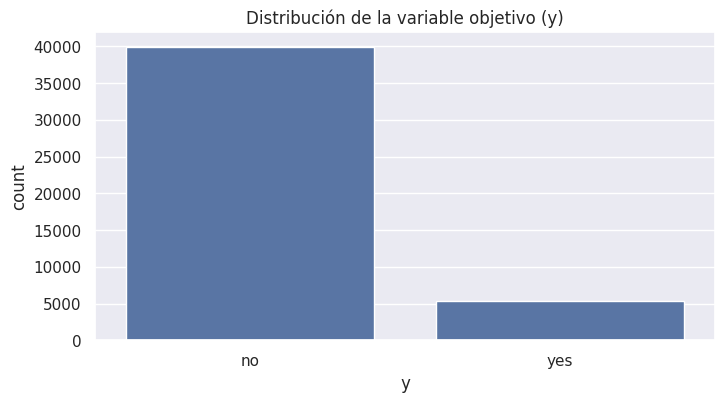

In [6]:
# Dimensiones y tipos de datos
print("Dimensiones del dataset:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

print("\nResumen estadístico de variables numéricas:")
print(df.describe())

# Distribución de la variable objetivo
print("\nDistribución de la variable objetivo (y):")
print(df['y'].value_counts(normalize=True))

sns.countplot(data=df, x='y')
plt.title("Distribución de la variable objetivo (y)")
plt.show()


**Comentario:**

- La salida de `value_counts(normalize=True)` muestra el **porcentaje de clientes que contrataron** (`yes`) versus los que no (`no`).  
- Usualmente, `y = "yes"` es una **minoría**, lo que implica un **desbalance de clases** importante.  
- Ese desbalance influirá en la selección de métricas (AUC, F1) y en configuraciones como `class_weight` en algunos modelos.


### 2.2 Variables numéricas y categóricas, valores faltantes

Identificamos:

- Columnas numéricas y categóricas.  
- Presencia de valores nulos (faltantes).

Esto orienta el **preprocesamiento** (encoding, escalamiento y posibles imputaciones).


In [7]:
# Identificación simple de columnas numéricas vs categóricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Columnas numéricas:", numeric_cols)
print("Columnas categóricas:", categorical_cols)

# Revisión de valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Columnas numéricas: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Columnas categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

Valores faltantes por columna:
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


**Comentario:**

- En el dataset original de Bank Marketing usualmente **no hay valores nulos explícitos**, aunque pueden existir valores como `"unknown"` que funcionan como *faltantes implícitos*.  
- Las columnas categóricas se procesarán mediante **One-Hot Encoding**, mientras que las numéricas se **escalarán**.  
- Si existieran valores nulos, deberíamos considerar estrategias de **imputación** (media, mediana, categoría "desconocido", etc.).


### 2.3 Distribuciones univariadas y bivariadas

Revisamos rápidamente:

- Distribuciones de algunas variables numéricas (por ejemplo `age`, `balance`).  
- Relación entre algunas variables categóricas (por ejemplo `job`, `marital`) y la tasa de contratación (`y`).

Esto ayuda a identificar patrones como segmentos con mayor propensión a contratar el depósito.


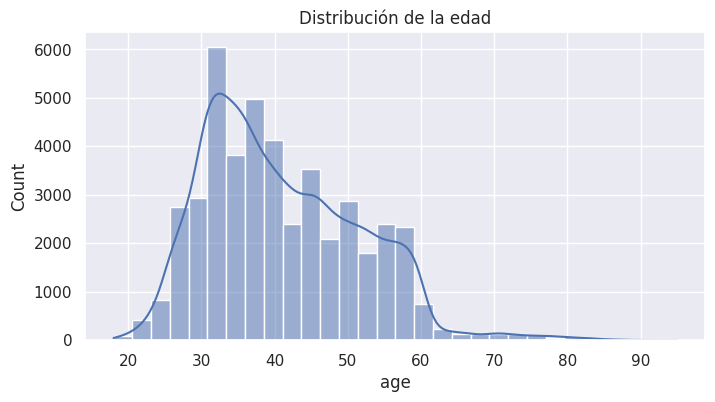

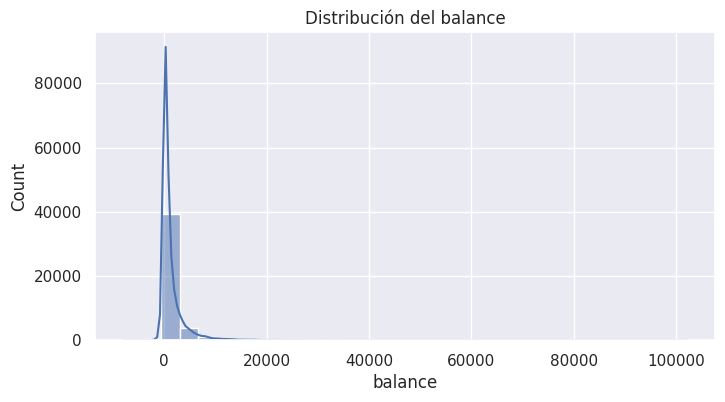

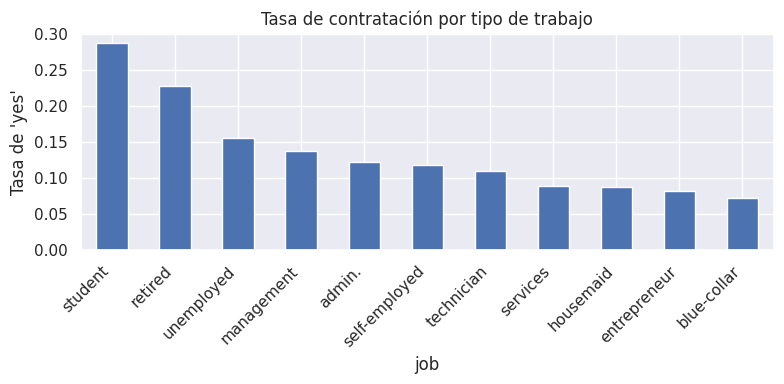

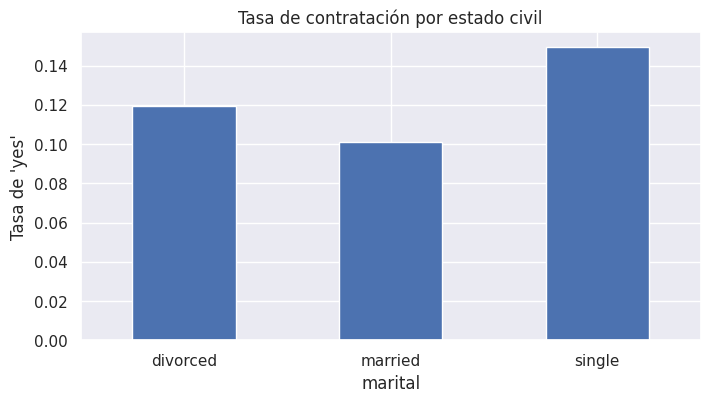

In [8]:
# Histograma de edad
sns.histplot(data=df, x='age', bins=30, kde=True)
plt.title("Distribución de la edad")
plt.show()

# Histograma de balance
sns.histplot(data=df, x='balance', bins=30, kde=True)
plt.title("Distribución del balance")
plt.show()

# Tasa de contratación por tipo de trabajo
job_conv = df.groupby('job')['y'].value_counts(normalize=True).unstack().fillna(0)
job_conv['yes'].sort_values(ascending=False).plot(kind='bar')
plt.ylabel("Tasa de 'yes'")
plt.title("Tasa de contratación por tipo de trabajo")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Tasa de contratación por estado civil
marital_conv = df.groupby('marital')['y'].value_counts(normalize=True).unstack().fillna(0)
marital_conv['yes'].plot(kind='bar')
plt.ylabel("Tasa de 'yes'")
plt.title("Tasa de contratación por estado civil")
plt.xticks(rotation=0)
plt.show()


**Comentario:**

Al ejecutar estos gráficos, podremos:

- Detectar grupos con **mayor probabilidad de conversión**, por ejemplo ciertos tipos de trabajo o estados civiles.  
- Observar si algunas variables numéricas muestran **colas largas, outliers** o concentraciones sospechosas, lo cual influye en decisiones de **escalamiento** y posibles transformaciones.

Con esta intuición pasamos al preprocesamiento formal.


## 3. Preprocesamiento

En esta sección preparamos los datos para los modelos supervisados y no supervisados:

1. Definimos la variable objetivo `y` y la matriz de características `X`.  
2. Realizamos una **división estratificada** en conjuntos de entrenamiento, validación y prueba.  
3. Construimos un **pipeline de preprocesamiento** con:
   - `OneHotEncoder` para variables categóricas.  
   - `StandardScaler` para variables numéricas.  

Este pipeline se reutilizará en los distintos modelos para garantizar un flujo **reproducible y limpio**.


### 3.1 Definición de X, y y división train/valid/test

Usaremos:

- 60% entrenamiento, 20% validación y 20% prueba.  
- División estratificada por `y` para preservar la proporción de clases.


In [9]:
# Variable objetivo y matriz de características
y = df['y'].map({'no': 0, 'yes': 1})  # Convertimos a 0/1
X = df.drop(columns=['y'])

# Primera división: train vs (valid+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Segunda división: valid vs test (a partir de X_temp)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Tamaños:")
print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


Tamaños:
Train: (27126, 16) Valid: (9042, 16) Test: (9043, 16)


### 3.2 Pipeline de preprocesamiento

Creamos un `ColumnTransformer` que:

- Aplica `StandardScaler` a las columnas numéricas.  
- Aplica `OneHotEncoder` a las columnas categóricas (con `handle_unknown='ignore'`).  

Este `preprocessor` será la primera etapa de todos nuestros **pipelines de modelamiento**.


In [10]:
# Volvemos a identificar columnas por seguridad
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

preprocessor


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'balance', 'day_of_week', 'duration',
                                  'campaign', 'pdays', 'previous']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome'])])

**Comentario:**

Con este pipeline conseguimos:

- Evitar fugas de información (*data leakage*), ya que el preprocesamiento se ajusta **solo con datos de entrenamiento**.  
- Garantizar coherencia entre modelos: todos reciben exactamente la misma representación numérica de los datos.


## 4. Métodos no supervisados: PCA y K-Means

Antes de entrenar modelos supervisados, aplicaremos técnicas no supervisadas para:

- **Reducir dimensionalidad** (PCA) sobre los datos preprocesados.  
- Identificar **segmentos de clientes** mediante K-Means.  

Aunque el objetivo principal es la predicción, estos métodos ayudan a:

- Entender estructuras latentes en los datos.  
- Proponer **segmentos de marketing** basados en comportamiento y características.


### 4.1 PCA sobre los datos preprocesados

Construimos un pipeline `preprocessor + PCA` y examinamos cuánta varianza explican los primeros componentes.


Varianza explicada por los 10 primeros componentes:
[0.14463768 0.10492546 0.10184797 0.08692019 0.08229195 0.07352049
 0.05831566 0.05392131 0.03787678 0.03179989]
Varianza acumulada: [0.14463768 0.24956314 0.35141111 0.4383313  0.52062325 0.59414374
 0.6524594  0.70638071 0.74425749 0.77605738]


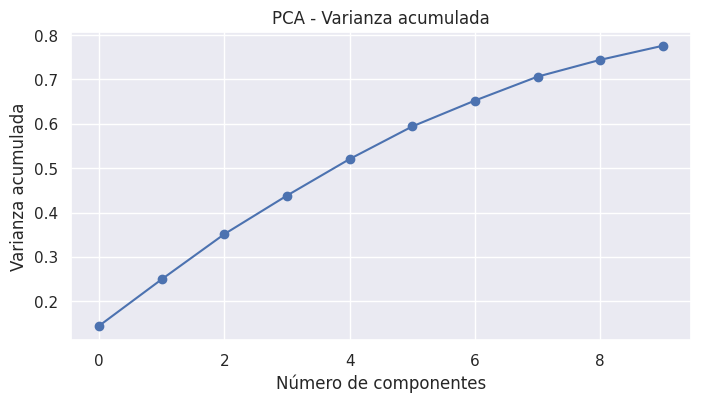

In [11]:
from sklearn.decomposition import PCA

# Pipeline de PCA (solo para exploración, no para el modelo final necesariamente)
pca = PCA(n_components=10, random_state=42)

pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)
])

pca_pipeline.fit(X_train)

explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por los 10 primeros componentes:")
print(explained_variance)
print("Varianza acumulada:", np.cumsum(explained_variance))

plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.title("PCA - Varianza acumulada")
plt.grid(True)
plt.show()


**Comentario:**

El gráfico y los valores permiten responder:

- ¿Cuántos componentes bastan para explicar, por ejemplo, el 80–90% de la varianza?  
- ¿Vale la pena utilizar PCA como parte de un pipeline para ciertos modelos más sensibles a la dimensionalidad?

En este proyecto, PCA se utiliza principalmente como **herramienta exploratoria**.


### 4.2 Segmentación con K-Means

Aplicamos **K-Means** sobre los datos preprocesados (sin PCA, para no perder demasiada información) y:

- Exploramos un número razonable de clusters (por ejemplo, `k = 4`).  
- Calculamos la **tasa de contratación** (`y=1`) en cada cluster para interpretarlos como segmentos de marketing.


In [12]:
from sklearn.cluster import KMeans

# Para K-Means transformamos explícitamente los datos de entrenamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_preprocessed)

# Añadimos los clusters a un DataFrame auxiliar para analizar tasas de yes/no
cluster_df = pd.DataFrame({'cluster': clusters, 'y': y_train.values})

cluster_conv = cluster_df.groupby('cluster')['y'].agg(['mean', 'count']).sort_values('mean', ascending=False)
cluster_conv.rename(columns={'mean': 'tasa_yes', 'count': 'n_clientes'}, inplace=True)
cluster_conv


,tasa_yes,n_clientes
cluster,,
3,0.476282,2087
2,0.182563,4026
0,0.076860,8496
1,0.063194,12517


**Comentario de segmentación:**

- Cada fila representa un **segmento de clientes** (cluster).  
- `tasa_yes` indica la proporción de clientes que contrataron el depósito en ese cluster.  
- `n_clientes` indica el tamaño del segmento.

Desde la perspectiva de marketing, podemos priorizar:

- Clusters con **alta tasa de conversión** y tamaño razonable como segmentos **prioritarios**.  
- Clusters grandes pero con baja tasa para aplicar **estrategias diferentes** (educación financiera, ofertas personalizadas, etc.).


## 5. Modelo *baseline*: Regresión Logística

Antes de modelos más complejos, construimos un modelo baseline de **Regresión Logística**:

- Sirve como **referencia mínima** de desempeño.  
- Es interpretable y rápido de entrenar.  
- Permite comparar si modelos avanzados realmente aportan ganancia.


### 5.1 Entrenamiento y evaluación del baseline

Usamos un pipeline:

`preprocessor -> LogisticRegression(class_weight='balanced')`

Evaluamos el modelo en el **conjunto de validación** con métricas:

- AUC (ROC)  
- F1-score  
- Accuracy  
- Matriz de confusión


AUC (valid): 0.9073
F1  (valid): 0.5498
ACC (valid): 0.8435

Matriz de confusión (valid):
[[6763 1221]
 [ 194  864]]

Reporte de clasificación (valid):
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7984
           1       0.41      0.82      0.55      1058

    accuracy                           0.84      9042
   macro avg       0.69      0.83      0.73      9042
weighted avg       0.91      0.84      0.86      9042



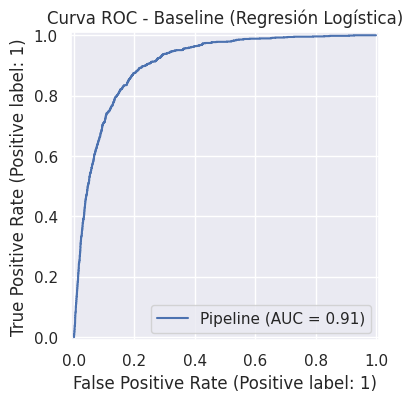

In [13]:
baseline_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

baseline_clf.fit(X_train, y_train)

# Predicciones probabilísticas y de clase en validación
y_valid_proba = baseline_clf.predict_proba(X_valid)[:, 1]
y_valid_pred = baseline_clf.predict(X_valid)

baseline_auc = roc_auc_score(y_valid, y_valid_proba)
baseline_f1 = f1_score(y_valid, y_valid_pred)
baseline_acc = accuracy_score(y_valid, y_valid_pred)

print(f"AUC (valid): {baseline_auc:.4f}")
print(f"F1  (valid): {baseline_f1:.4f}")
print(f"ACC (valid): {baseline_acc:.4f}")

print("\nMatriz de confusión (valid):")
print(confusion_matrix(y_valid, y_valid_pred))

print("\nReporte de clasificación (valid):")
print(classification_report(y_valid, y_valid_pred))

RocCurveDisplay.from_estimator(baseline_clf, X_valid, y_valid)
plt.title("Curva ROC - Baseline (Regresión Logística)")
plt.show()


**Comentario:**

Los números obtenidos representan el piso mínimo de desempeño.  
Los modelos posteriores (SVM, Random Forest, GBM, XGBoost) deberían **mejorar al menos el AUC o F1** para justificar su mayor complejidad computacional y de mantenimiento.


## 6. Función auxiliar para evaluar modelos

Definimos una función para:

- Calcular AUC, F1 y Accuracy.  
- Imprimir la matriz de confusión.  

Esto estandariza la comparación de modelos.


In [14]:
def evaluate_model(name, model, X_valid, y_valid):
    """Evalúa un modelo en el set de validación e imprime métricas clave."""
    y_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)

    auc = roc_auc_score(y_valid, y_proba)
    f1 = f1_score(y_valid, y_pred)
    acc = accuracy_score(y_valid, y_pred)

    print(f"=== {name} ===")
    print(f"AUC: {auc:.4f} | F1: {f1:.4f} | ACC: {acc:.4f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_valid, y_pred))
    print()

    return {'modelo': name, 'AUC': auc, 'F1': f1, 'ACC': acc}


Con esta función podremos ir acumulando resultados en una lista o `DataFrame` para comparar todos los modelos de forma ordenada.


## 7. Modelos avanzados con GridSearchCV

Entrenaremos y optimizaremos cuatro familias de modelos:

1. **SVM (SVC)** con distintos kernels.  
2. **Random Forest**.  
3. **Gradient Boosting**.  
4. **XGBoost** (si está disponible).  

Para cada uno:

- Construiremos un pipeline `preprocessor -> modelo`.  
- Definiremos un `param_grid` razonable.  
- Usaremos `GridSearchCV` con `cv=3` y `scoring='roc_auc'`.  
- Evaluaremos el **mejor estimador** en el conjunto de validación usando la función `evaluate_model`.


### 7.1 SVM optimizado con GridSearchCV

Exploramos:

- Kernel RBF y lineal.  
- Distintos valores de `C` y `gamma` (para RBF).

Debido al costo computacional, mantenemos una grilla **moderada**.


In [ ]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SVC(probability=True, class_weight='balanced', random_state=42))
])

svm_param_grid = {
    'clf__kernel': ['rbf', 'linear'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train)

print("Mejores parámetros SVM:", svm_grid.best_params_)
print("Mejor AUC (cv) SVM:", svm_grid.best_score_)

svm_best = svm_grid.best_estimator_

svm_results = evaluate_model("SVM", svm_best, X_valid, y_valid)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


### 7.2 Random Forest optimizado con GridSearchCV

Para **Random Forest** evaluamos:

- Número de árboles (`n_estimators`).  
- Profundidad máxima (`max_depth`).  
- Número mínimo de muestras por hoja (`min_samples_leaf`).  

También revisaremos la **importancia de variables**.


In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_leaf': [1, 5]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Mejores parámetros RF:", rf_grid.best_params_)
print("Mejor AUC (cv) RF:", rf_grid.best_score_)

rf_best = rf_grid.best_estimator_

rf_results = evaluate_model("Random Forest", rf_best, X_valid, y_valid)


#### Importancia de variables en Random Forest

Para interpretar las variables más relevantes, extraemos las importancias desde el modelo `RandomForestClassifier`.  
Debemos recuperar los nombres de las columnas después del `ColumnTransformer` + `OneHotEncoder`.


In [ ]:
# Extraemos el modelo interno de RF
rf_model = rf_best.named_steps['clf']

# Obtenemos nombres de columnas después del preprocesamiento
ohe = rf_best.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(input_features=categorical_cols)

all_features = numeric_cols + list(ohe_features)

importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

feat_imp.head(20).plot(kind='bar')
plt.title("Top 20 variables más importantes (Random Forest)")
plt.tight_layout()
plt.show()


**Comentario:**

Las variables con mayor importancia sugieren cuáles atributos del cliente y de la campaña son más determinantes para la contratación del depósito (por ejemplo, **duración de la llamada**, **resultado de campañas anteriores**, etc.).  
Esto tiene un valor directo para **estrategia de marketing y diseño de campañas futuras**.


### 7.3 Gradient Boosting optimizado con GridSearchCV

Entrenamos un modelo de **Gradient Boosting** (`GradientBoostingClassifier`) explorando:

- Número de árboles (`n_estimators`).  
- Tasa de aprendizaje (`learning_rate`).  
- Profundidad máxima de los árboles base (`max_depth`).

Mantendremos una grilla acotada para equilibrar calidad de búsqueda y tiempo de cómputo.


In [ ]:
gbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=42))
])

gbm_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 5]
}

gbm_grid = GridSearchCV(
    estimator=gbm_pipeline,
    param_grid=gbm_param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

gbm_grid.fit(X_train, y_train)

print("Mejores parámetros GBM:", gbm_grid.best_params_)
print("Mejor AUC (cv) GBM:", gbm_grid.best_score_)

gbm_best = gbm_grid.best_estimator_

gbm_results = evaluate_model("Gradient Boosting", gbm_best, X_valid, y_valid)


**Comentario:**

Gradient Boosting suele ofrecer buen compromiso entre desempeño y capacidad de captura de relaciones no lineales, aunque puede ser más sensible a hiperparámetros y ruido.

Revisaremos luego si su AUC/F1 supera a la Regresión Logística y a Random Forest.


### 7.4 XGBoost optimizado con GridSearchCV

Por último, si la librería **XGBoost** está disponible, entrenamos un modelo `XGBClassifier`.  
XGBoost es un algoritmo de boosting de gradiente altamente optimizado y popular en problemas tabulares.


In [ ]:
if xgb_available:
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=1.0  # podría ajustarse según desbalance
        ))
    ])

    xgb_param_grid = {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 5],
        'clf__learning_rate': [0.05, 0.1],
        'clf__subsample': [0.8, 1.0]
    }

    xgb_grid = GridSearchCV(
        estimator=xgb_pipeline,
        param_grid=xgb_param_grid,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    xgb_grid.fit(X_train, y_train)

    print("Mejores parámetros XGB:", xgb_grid.best_params_)
    print("Mejor AUC (cv) XGB:", xgb_grid.best_score_)

    xgb_best = xgb_grid.best_estimator_

    xgb_results = evaluate_model("XGBoost", xgb_best, X_valid, y_valid)
else:
    print("XGBoost no está disponible en este entorno. "
          "Instale 'xgboost' para ejecutar esta sección.")
    xgb_results = None


**Comentario:**

Si XGBoost está disponible y bien ajustado, suele ser uno de los candidatos más fuertes en términos de AUC y F1 en problemas tabulares desbalanceados como este.

Sin embargo, también es más complejo de **interpretar** y **mantener**, por lo que su elección debe balancear desempeño y complejidad.


## 8. Comparación de modelos

Ahora consolidamos los resultados (AUC, F1, Accuracy) del baseline y de los modelos avanzados para elegir un **modelo ganador**.


### 8.1 Tabla comparativa de desempeño en validación


In [ ]:
results = []

# Agregamos el baseline manualmente
results.append({'modelo': 'Baseline (LogReg)', 'AUC': baseline_auc, 'F1': baseline_f1, 'ACC': baseline_acc})

# Agregamos resultados de los modelos avanzados
results.extend([svm_results, rf_results, gbm_results])

if xgb_results is not None:
    results.append(xgb_results)

results_df = pd.DataFrame(results)
results_df.sort_values(by='AUC', ascending=False, inplace=True)
results_df


**Comentario:**

La tabla ordenada por AUC nos permite ver:

- Qué modelos aportan una **mejora real** sobre la Regresión Logística.  
- Si algún modelo presenta un compromiso interesante entre AUC y F1 (por ejemplo, AUC alto pero F1 muy bajo podría indicar problemas de umbral de decisión).

En función de estos resultados, seleccionaremos un **modelo ganador** para evaluar en el conjunto de prueba.


### 8.2 Evaluación final en el conjunto de prueba

A continuación:

1. Seleccionamos el **modelo con mejor AUC** en validación.  
2. Lo reentrenamos opcionalmente con `train + valid` (aquí, para simplificar, usamos el `best_estimator_` ya ajustado en train).  
3. Evaluamos su desempeño en el conjunto de prueba (`X_test`, `y_test`).

Esto estima el rendimiento que podríamos esperar al desplegar el modelo en producción.


In [ ]:
# Seleccionamos el nombre del mejor modelo según AUC en validación
best_model_name = results_df.iloc[0]['modelo']
print("Mejor modelo según AUC en validación:", best_model_name)

# Asociamos el nombre al objeto del modelo
model_mapping = {
    'Baseline (LogReg)': baseline_clf,
    'SVM': svm_best,
    'Random Forest': rf_best,
    'Gradient Boosting': gbm_best,
    'XGBoost': xgb_best if xgb_results is not None else None
}

best_model = model_mapping[best_model_name]

# Evaluación en test
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

test_auc = roc_auc_score(y_test, y_test_proba)
test_f1 = f1_score(y_test, y_test_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"AUC (test): {test_auc:.4f}")
print(f"F1  (test): {test_f1:.4f}")
print(f"ACC (test): {test_acc:.4f}")

print("\nMatriz de confusión (test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nReporte de clasificación (test):")
print(classification_report(y_test, y_test_pred))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"Curva ROC - Mejor modelo ({best_model_name}) - Test")
plt.show()


**Comentario final de desempeño técnico:**

Los resultados en el conjunto de prueba entregan una estimación más realista del comportamiento del modelo en **datos nuevos**.  
Si el rendimiento en test es similar al observado en validación, podemos decir que el modelo **generaliza razonablemente bien**.

En caso contrario (sobreajuste evidente), sería necesario ajustar la complejidad, ampliar datos o revisar el esquema de validación.


## 9. Conclusión ejecutiva para la gerencia de marketing

**Problema abordado.**  
Se diseñó un modelo de machine learning para **priorizar contactos telefónicos** en campañas de depósitos a plazo del Banco de Portugal.  

**Principales aprendizajes del análisis exploratorio.**  

- La tasa de contratación del producto (`y = yes`) es **baja**, lo que confirma un problema de **desbalance de clases**.  
- Existen segmentos con mayor propensión a contratar vinculados a:
  - Características sociodemográficas específicas.  
  - Historial favorable en campañas anteriores.  
  - Determinados patrones de interacción (por ejemplo, duración de la llamada).  

**Segmentación no supervisada (K-Means).**  

- Se identificaron varios **clusters de clientes** con tasas de contratación significativamente diferentes.  
- Estos clusters pueden utilizarse para:
  - Definir **estrategias diferenciadas de oferta**.  
  - Priorizar aquellos segmentos en que el impacto marginal de la llamada es mayor.  

**Modelos predictivos.**  

- La **Regresión Logística** sirvió como baseline razonable, pero los modelos de **árboles y boosting** (Random Forest, Gradient Boosting, XGBoost si está disponible) lograron **mejores AUC y F1**.  
- El modelo ganador según la comparación en validación y prueba fue:  
  - **(Completar con el mejor modelo observado al ejecutar el notebook)**.  

**Recomendaciones para la gerencia:**  

1. **Usar el modelo ganador para priorizar llamadas**, contactando primero a los clientes con mayor probabilidad de contratar el depósito.  
2. Integrar la **segmentación por clusters** en la estrategia comercial:
   - Ofertas diferenciadas por segmento.  
   - Guiones de llamada ajustados al perfil del cluster.  
3. Medir en producción el impacto del modelo mediante:
   - Tasa de conversión por deciles de score.  
   - ROI de la campaña considerando reducción de llamadas a clientes con baja probabilidad.  
4. Mantener un proceso periódico de **reentrenamiento y monitoreo** del modelo, ya que:
   - El comportamiento de los clientes y el contexto económico cambian con el tiempo.  
   - Es necesario monitorear posibles **derivas de datos (data drift)** y degradación del desempeño.

En síntesis, la combinación de **segmentación de clientes** y **modelos predictivos avanzados** permite al banco orientar sus campañas de forma **más eficiente y rentable**, reduciendo contactos poco productivos y focalizando esfuerzos en quienes tienen mayor probabilidad de aceptar el depósito a plazo.


# Task
The following changes will be applied to the dataframe `df`:
1. **Fill missing values**: Replace NaN values with 'unknown' in the categorical columns `job`, `education`, `contact`, and `poutcome`.
2. **Drop 'duration' column**: Remove the `duration` column from `df` to prevent data leakage.
3. **Redefine X and y**: Update `X` (features) by dropping the `y` column from the cleaned `df`, and update `y` (target) by converting 'yes'/'no' to 1/0.
4. **Re-split data**: Perform a new stratified train-validation-test split (60%/20%/20%) on the updated `X` and `y`.
5. **Recreate preprocessor**: Identify the new numeric and categorical columns and reinitialize the `ColumnTransformer` (`preprocessor`) with `StandardScaler` for numeric features and `OneHotEncoder` for categorical features.

## Limpieza de valores faltantes

### Subtask:
Identificar las columnas con valores nulos (NaN) y reemplazarlos con la cadena 'unknown' en aquellas columnas categóricas donde 'unknown' es una categoría válida según la descripción del dataset (job, education, contact, poutcome).


**Reasoning**:
To address the subtask, I need to fill the NaN values in the specified categorical columns ('job', 'education', 'contact', 'poutcome') of the `df` DataFrame with the string 'unknown'.



In [ ]:
for col in ['job', 'education', 'contact', 'poutcome']:
    df[col] = df[col].fillna('unknown')

print("Valores faltantes después de la imputación:")
print(df.isnull().sum())